In [1]:
import pandas as pd
import os
import sys
import seaborn as sns
import matplotlib.pyplot as plt
from forex_python.converter import CurrencyRates
cwd = os.getcwd()
import re
import math
import numpy as np
pd.reset_option('^display.', silent=True)
np.set_printoptions(suppress=True)



In [2]:
imdb_df = pd.read_csv(cwd+'/datasets/imdb.csv')  #import imdb csv

In [3]:
#initiating data preparation
#Printing columns to understand the dataset
imdb_df.columns

Index(['imdb_title_id', 'title', 'original_title', 'year', 'date_published',
       'genre', 'duration', 'country', 'language', 'director', 'writer',
       'production_company', 'actors', 'description', 'avg_vote', 'votes',
       'budget', 'usa_gross_income', 'worlwide_gross_income', 'metascore',
       'reviews_from_users', 'reviews_from_critics'],
      dtype='object')

In [4]:
#First, let's get a macroview of which columns are useful and which ones aren't

imdb_df.isna().sum()/imdb_df.shape[0] * 100

imdb_title_id             0.000000
title                     0.000000
original_title            0.000000
year                      0.000000
date_published            0.000000
genre                     0.000000
duration                  0.000000
country                   0.047986
language                  0.928968
director                  0.089821
writer                    1.837018
production_company        5.321571
actors                    0.081208
description               2.989923
avg_vote                  0.000000
votes                     0.000000
budget                   71.941481
usa_gross_income         81.428027
worlwide_gross_income    63.220258
metascore                84.346585
reviews_from_users        8.707689
reviews_from_critics     13.518635
dtype: float64

In [5]:
#we will drop the Nan rows from output and also from metscore since 84% of its values are missing 
imdb_df = imdb_df.drop(columns=['metascore'])

In [6]:
#Then, we will remove the rows from imdb_df that do not have worldwide & usa revenue numbers as this is the output we are looking to compare with

imdb_df = imdb_df.dropna(subset=['worlwide_gross_income'])

In [7]:
#Genre column can serve as a great categorical variable
imdb_df['genre'] = imdb_df['genre'].str.replace(' ', '') # But first, we need to split the genres separated by commas
genre_encoded = imdb_df['genre'].str.get_dummies(sep=',') #We encode the genres by using get_dummies
genre_encoded

,Action,Adventure,Animation,Biography,Comedy,Crime,Documentary,Drama,Family,Fantasy,...,Horror,Music,Musical,Mystery,Romance,Sci-Fi,Sport,Thriller,War,Western
155,0,0,0,0,0,0,0,0,0,1,...,1,0,0,1,0,0,0,0,0,0
198,0,0,0,0,0,0,0,1,0,0,...,0,0,0,0,0,0,0,0,0,0
210,0,0,0,0,1,0,0,1,0,0,...,0,0,0,0,1,0,0,0,0,0
232,0,0,0,0,0,0,0,1,0,0,...,0,0,0,0,1,0,0,0,1,0
238,0,0,0,0,1,0,0,1,1,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
81264,0,0,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
81265,0,1,1,0,0,0,0,0,1,0,...,0,0,0,0,0,0,0,0,0,0
81267,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0
81269,0,0,0,0,0,0,0,1,0,0,...,0,0,0,0,0,0,0,0,0,0


In [8]:
imdb_df = pd.concat([imdb_df,genre_encoded], axis=1) #join the encoded data with original dataframe
imdb_df.drop(columns=['genre']) #drop the original genre column

,imdb_title_id,title,original_title,year,date_published,duration,country,language,director,writer,...,Horror,Music,Musical,Mystery,Romance,Sci-Fi,Sport,Thriller,War,Western
155,tt0010323,Das Cabinet des Dr. Caligari,Das Cabinet des Dr. Caligari,1920,1920-02-27,76,Germany,German,Robert Wiene,"Carl Mayer, Hans Janowitz",...,1,0,0,1,0,0,0,0,0,0
198,tt0011440,Markens grøde,Markens grøde,1921,1921-12-02,107,Norway,NaN,Gunnar Sommerfeldt,"Knut Hamsun, Gunnar Sommerfeldt",...,0,0,0,0,0,0,0,0,0,0
210,tt0011741,Suds,Suds,1920,1920-01-27,75,USA,English,John Francis Dillon,"Waldemar Young, Richard Bryce",...,0,0,0,0,1,0,0,0,0,0
232,tt0012190,The Four Horsemen of the Apocalypse,The Four Horsemen of the Apocalypse,1921,1923-01-08,150,USA,None,Rex Ingram,"Vicente Blasco Ibáñez, June Mathis",...,0,0,0,0,1,0,0,0,1,0
238,tt0012349,The Kid,The Kid,1921,1921-02-06,68,USA,English,Charles Chaplin,Charles Chaplin,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
81264,tt9894394,Upin & Ipin: Keris Siamang Tunggal,Upin & Ipin: Keris Siamang Tunggal,2019,2019-03-21,100,Malaysia,Malay,"Adam Bin Amiruddin, Syed Nurfaiz Khalid bin Sy...","Hjh. Ainon Ariff, Nur Naquyah bt Burhanuddin",...,0,0,0,0,0,0,0,0,0,0
81265,tt9896916,The Pilgrim's Progress,The Pilgrim's Progress,2019,2019-04-18,108,USA,English,Robert Fernandez,"John Bunyan, Robert Fernandez",...,0,0,0,0,0,0,0,0,0,0
81267,tt9900782,Kaithi,Kaithi,2019,2019-10-25,145,India,Tamil,Lokesh Kanagaraj,Lokesh Kanagaraj,...,0,0,0,0,0,0,0,1,0,0
81269,tt9905412,Ottam,Ottam,2019,2019-03-08,120,India,Malayalam,Zam,Rajesh k Narayan,...,0,0,0,0,0,0,0,0,0,0


In [9]:
c = CurrencyRates() #instantiating the forex conversion module                       

In [10]:
#function for reading in the currency and converting to USD
def get_symbol(price):
        import re
        pattern =  r'(\D*)\d*\.?\d*(\D*)'
        g = re.match(pattern,price).groups()
        return g[0]

def return_USD(budget):
    if budget!='nan':
        if '$' not in budget:
            try:
               return c.get_rate(get_symbol(budget).strip(), 'USD') * int(re.findall('\d+', budget)[0])
            except:
               return float('NaN')
        else:
            return int(re.findall('\d+', budget)[0])
    else: 
        return float('NaN')

In [11]:
#lambda function for applying the USD conversion to the budget column
imdb_df['budget'] = imdb_df['budget'].apply(lambda x: return_USD(str(x)))
imdb_df


,imdb_title_id,title,original_title,year,date_published,genre,duration,country,language,director,...,Horror,Music,Musical,Mystery,Romance,Sci-Fi,Sport,Thriller,War,Western
155,tt0010323,Das Cabinet des Dr. Caligari,Das Cabinet des Dr. Caligari,1920,1920-02-27,"Fantasy,Horror,Mystery",76,Germany,German,Robert Wiene,...,1,0,0,1,0,0,0,0,0,0
198,tt0011440,Markens grøde,Markens grøde,1921,1921-12-02,Drama,107,Norway,NaN,Gunnar Sommerfeldt,...,0,0,0,0,0,0,0,0,0,0
210,tt0011741,Suds,Suds,1920,1920-01-27,"Comedy,Drama,Romance",75,USA,English,John Francis Dillon,...,0,0,0,0,1,0,0,0,0,0
232,tt0012190,The Four Horsemen of the Apocalypse,The Four Horsemen of the Apocalypse,1921,1923-01-08,"Drama,Romance,War",150,USA,None,Rex Ingram,...,0,0,0,0,1,0,0,0,1,0
238,tt0012349,The Kid,The Kid,1921,1921-02-06,"Comedy,Drama,Family",68,USA,English,Charles Chaplin,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
81264,tt9894394,Upin & Ipin: Keris Siamang Tunggal,Upin & Ipin: Keris Siamang Tunggal,2019,2019-03-21,Animation,100,Malaysia,Malay,"Adam Bin Amiruddin, Syed Nurfaiz Khalid bin Sy...",...,0,0,0,0,0,0,0,0,0,0
81265,tt9896916,The Pilgrim's Progress,The Pilgrim's Progress,2019,2019-04-18,"Animation,Adventure,Family",108,USA,English,Robert Fernandez,...,0,0,0,0,0,0,0,0,0,0
81267,tt9900782,Kaithi,Kaithi,2019,2019-10-25,"Action,Thriller",145,India,Tamil,Lokesh Kanagaraj,...,0,0,0,0,0,0,0,1,0,0
81269,tt9905412,Ottam,Ottam,2019,2019-03-08,Drama,120,India,Malayalam,Zam,...,0,0,0,0,0,0,0,0,0,0


In [12]:
#similarly, we'll convert the worldwide_gross_income and usa_gross_icome to USD
imdb_df['worlwide_gross_income'] = imdb_df['worlwide_gross_income'].apply(lambda x: return_USD(str(x)))
imdb_df['usa_gross_income'] = imdb_df['usa_gross_income'].apply(lambda x: return_USD(str(x)))

In [14]:
imdb_df.to_csv(cwd+'/datasets/imdb_clean.csv') #we will save the cleaned up dataframe to a csv in order to create a milestone

In [18]:
#Next, we will attempt at building a machine learning model to see if we can predict the relative success of a movie by looking at some input variables
#Only use quantitative variables and drop any rows with missing values
num_vars = imdb_df[['year', 'duration', 'avg_vote', 'votes', 'budget',
       'worlwide_gross_income', 'reviews_from_users',
       'reviews_from_critics', 'Action', 'Adventure', 'Animation', 'Biography',
       'Comedy', 'Crime', 'Documentary', 'Drama', 'Family', 'Fantasy',
       'Film-Noir', 'History', 'Horror', 'Music', 'Musical', 'Mystery',
       'Romance', 'Sci-Fi', 'Sport', 'Thriller', 'War', 'Western']]
imdb_df_dropna = num_vars.dropna(axis=0)

In [19]:
#Split into explanatory and response variables

X = imdb_df_dropna[['year', 'duration', 'avg_vote', 'votes', 'budget','reviews_from_users',
       'reviews_from_critics', 'Action', 'Adventure', 'Animation', 'Biography',
       'Comedy', 'Crime', 'Documentary', 'Drama', 'Family', 'Fantasy',
       'Film-Noir', 'History', 'Horror', 'Music', 'Musical', 'Mystery',
       'Romance', 'Sci-Fi', 'Sport', 'Thriller', 'War', 'Western']]
y = imdb_df_dropna['worlwide_gross_income']

In [20]:
#We are going to use scikit learn's LinearRegression module to generate a train, test split with a test_size of 30%. 
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score, mean_squared_error
X_train, X_test, y_train, y_test = train_test_split(X,y, test_size=0.30, random_state=42)

In [21]:
lm_model = LinearRegression(normalize=True) # Instantiate the model
lm_model.fit(X_train, y_train)#Perform fitting

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=True)

In [22]:
y_test_preds = lm_model.predict(X_test) #Predict and score the model


In [23]:
r2_score(y_test, y_test_preds) #Generate r2_score

0.6906908776985097

In [26]:
#Next, we will attempt to answer certain business questions
#First question - Do certain genres make more $ than others?
#We will extract the grenres columns and save them into a new dataframe
imdb_genres_df = imdb_df[['worlwide_gross_income','Animation', 'Biography', 'Comedy', 'Crime', 'Documentary', 'Drama',
       'Family', 'Fantasy', 'Film-Noir', 'History', 'Horror', 'Music',
       'Musical', 'Mystery', 'Romance', 'Sci-Fi', 'Sport', 'Thriller', 'War',
       'Western' ]]

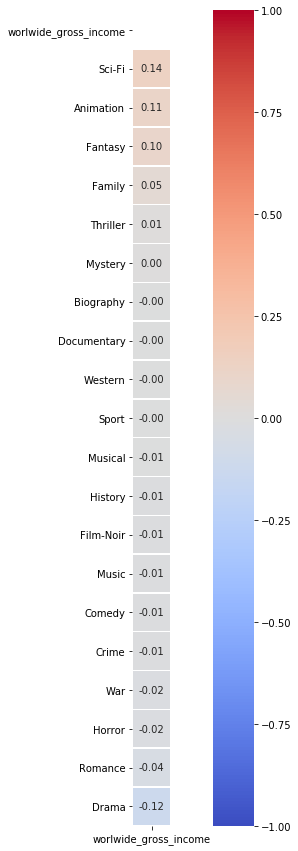

In [27]:
#We will make use of seaborn to generate a heatmap of correlations between various genres and the worldwide gross income
fig, ax = plt.subplots(figsize=(15,15)) #instantiate the plot
income_corr = imdb_genres_df.corr() #calculate correlation 
mask = np.zeros_like(income_corr[['worlwide_gross_income']], dtype=np.bool) #masking all the 1 values since they don't add any value
mask[np.triu_indices_from(mask)] = True #masking list
sns.heatmap(income_corr[['worlwide_gross_income']].sort_values(by=['worlwide_gross_income'],ascending=False), annot=True, fmt=".2f",linewidths=.5, ax=ax, vmin=-1, square=True, mask = mask, cmap='coolwarm');

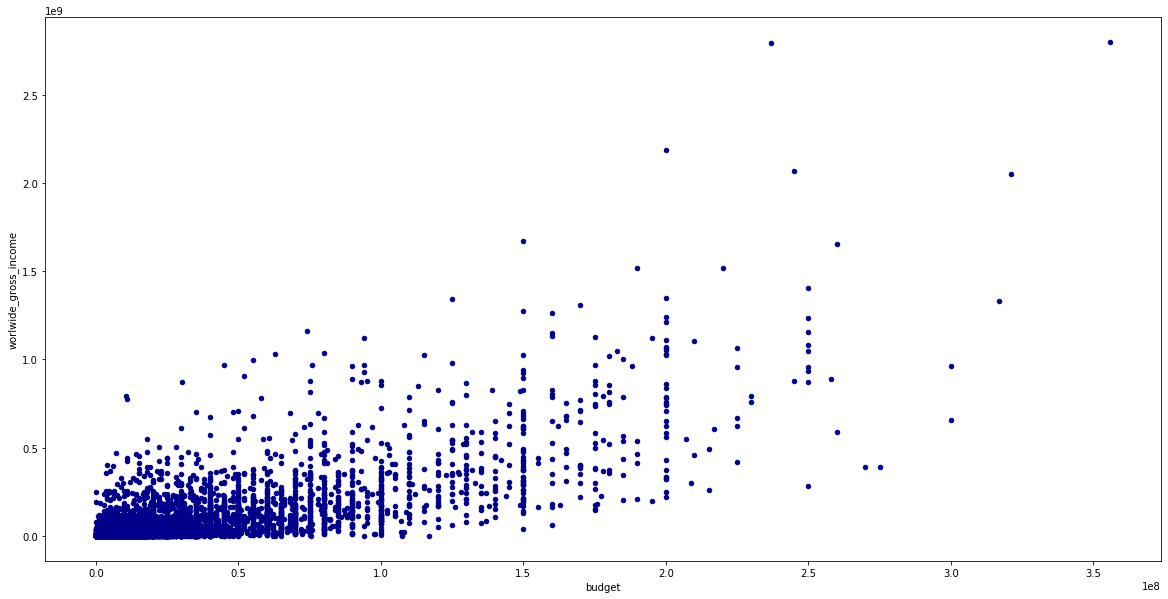

In [29]:
#Question 2 - Does the amount of funding for a movie have an impact on commercial success?
#We will generate a scatter plot of the budget vs worldwide_gross_income to assess the distribution 
imdb_df.plot.scatter(x='budget',
                      y='worlwide_gross_income',
                      c='DarkBlue', figsize=(20,10),style='plain')

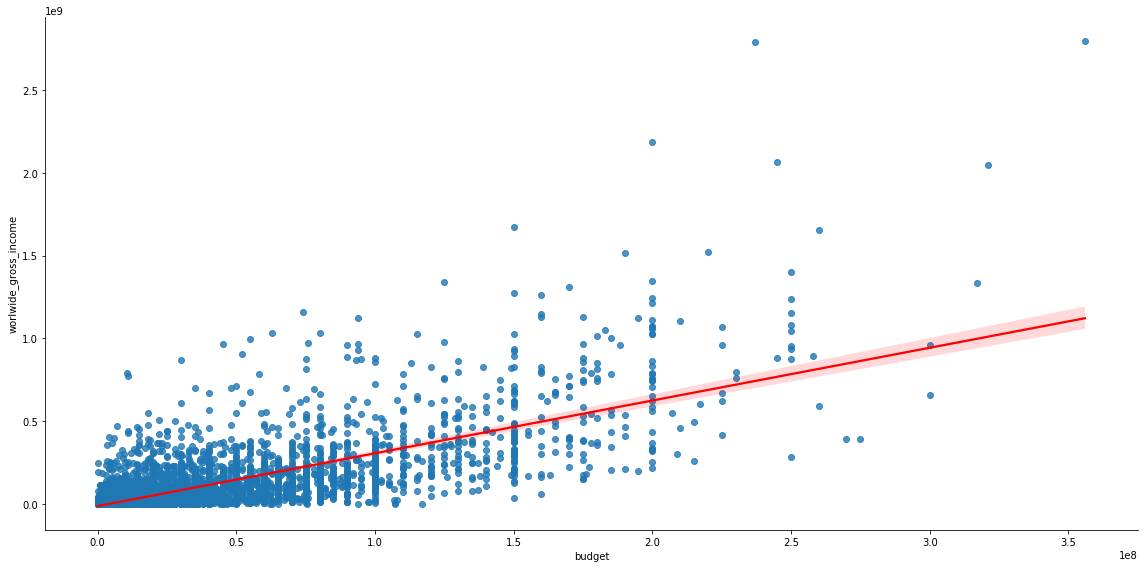

In [30]:
#based on the above plot, we can somewhat infer that budget and gross income are correlated. Let's see if we can draw a regression line to fit the plot
sns.lmplot(x='budget',y='worlwide_gross_income',data=imdb_df,fit_reg=True,line_kws={'color': 'red'},height=8, aspect=2)

In [75]:
#Clearly, there is correlation. Let's calculate the Pearson correltion between the two columns.
imdb_df['budget'].corr(imdb_df['worlwide_gross_income'])

0.7605672343714261

In [ ]:
#Highly correlated!

In [31]:
#What impact does duration have on the success of a movie?
imdb_df['duration'].describe()

count    29892.000000
mean       105.312793
std         20.518583
min         45.000000
25%         92.000000
50%        101.000000
75%        114.000000
max        808.000000
Name: duration, dtype: float64

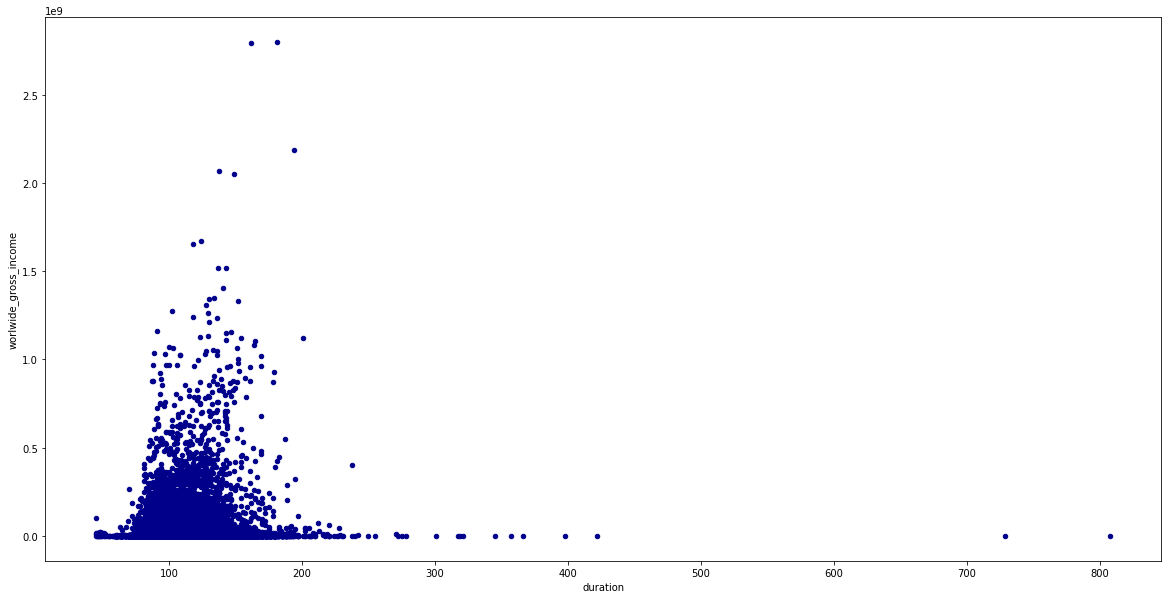

In [32]:
#We will generate a scatter plot of the duration vs worldwide_gross_income to assess the distribution 

imdb_df.plot.scatter(x='duration',
                      y='worlwide_gross_income',
                      c='DarkBlue', figsize=(20,10))

In [36]:
#The average length of a movie in our database is 105 minutes. Anything less or more tends to taper off the commercial value.
#We will seperate the duration into buckets
imdb_df['duration_binned'] = pd.cut(imdb_df['duration'], [0,30,60,90,120,150,180,210,240,270,300])

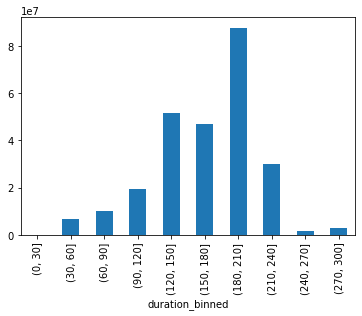

In [37]:
#We will then generate a bar chart distribution
imdb_df.groupby('duration_binned')['worlwide_gross_income'].mean().plot.bar()
#It seems the ideal movie falls within the bucket of 180 minutes to 210 minutes.

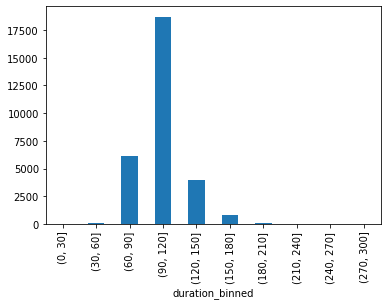

In [39]:
imdb_df.groupby('duration_binned')['worlwide_gross_income'].count().plot.bar()
#Turns out that the average commercial value in the 180-210 bucket which is high seems to be driven by a small number of highly successful movies.

In [40]:
imdb_df.groupby('duration')['worlwide_gross_income'].mean().idxmax() #For context, let's understand which movie is the source of greatest success

194

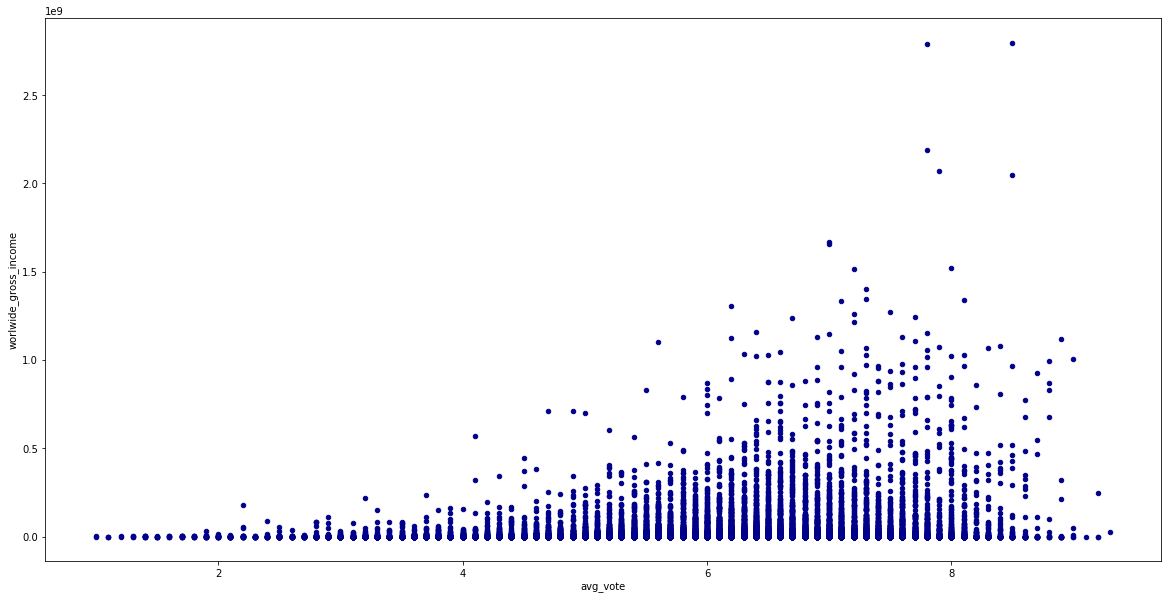

In [42]:
#Question 4- do votes - both in terms of user ratings have an impact on the success of a movie?
#We will generate a scatter plot of the avg_vote vs worldwide_gross_income to assess the distribution 

imdb_df.plot.scatter(x='avg_vote',
                      y='worlwide_gross_income',
                      c='DarkBlue',figsize=(20,10))

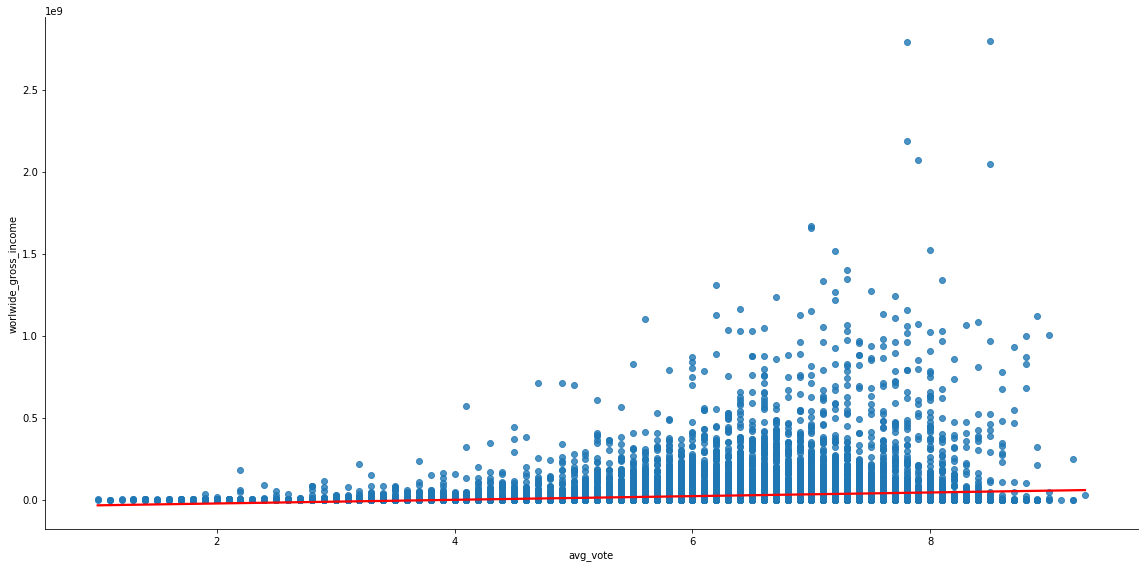

In [45]:
#We will draw a regression line to see if there's some correlation
sns.lmplot(x='avg_vote',y='worlwide_gross_income',data=imdb_df,fit_reg=True,line_kws={'color': 'red'},height=8, aspect=2)

In [47]:
#Shocking!  Let's calculate the Pearson correltion between the two columns.
imdb_df['avg_vote'].corr(imdb_df['worlwide_gross_income'])

0.13708938044484387

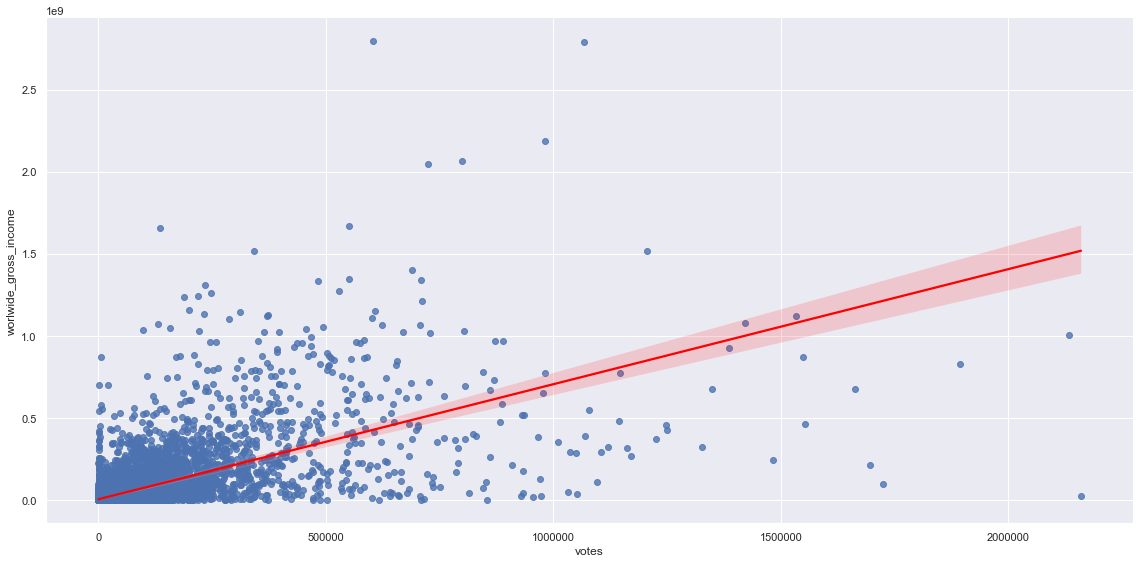

In [46]:
#Question 5 - similar to Question 4, what about the number of votes?
import matplotlib.pyplot as plt
sns.set()


sns.lmplot(x='votes',y='worlwide_gross_income',data=imdb_df,fit_reg=True,line_kws={'color': 'red'},height=8, aspect=2)

In [48]:
#Clearly, there is correlation. Let's calculate the Pearson correltion between the two columns.
imdb_df['votes'].corr(imdb_df['worlwide_gross_income'])

0.6592666121347268